In [99]:
import numpy as np
import pandas as pd
import yfinance as yf

In [100]:
stock_symbol = 'WIPRO.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [101]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,1.125000,1.125000,1.125000,1.125000,0.908191,19999
1996-01-02,1.037500,1.037500,1.037500,1.037500,0.837554,39999
1996-01-03,1.075000,1.075000,1.075000,1.075000,0.867827,19999
1996-01-04,1.075000,1.075000,1.075000,1.075000,0.867827,119999
1996-01-05,1.075000,1.075000,1.075000,1.075000,0.867827,0
...,...,...,...,...,...,...
2024-04-25,458.899994,462.549988,455.799988,461.000000,461.000000,5902545
2024-04-26,461.899994,475.799988,461.600006,464.600006,464.600006,10739147
2024-04-29,467.649994,468.000000,461.600006,462.950012,462.950012,3624970


In [102]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [103]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [104]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [105]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 10s 20ms/step - loss: 0.0027
Epoch 2/50
221/221 [==============================] - 4s 20ms/step - loss: 0.0010
Epoch 3/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0010
Epoch 4/50
221/221 [==============================] - 3s 15ms/step - loss: 9.0643e-04
Epoch 5/50
221/221 [==============================] - 3s 12ms/step - loss: 7.8232e-04
Epoch 6/50
221/221 [==============================] - 3s 12ms/step - loss: 7.4570e-04
Epoch 7/50
221/221 [==============================] - 3s 12ms/step - loss: 6.3714e-04
Epoch 8/50
221/221 [==============================] - 3s 15ms/step - loss: 6.4842e-04
Epoch 9/50
221/221 [==============================] - 3s 12ms/step - loss: 5.9899e-04
Epoch 10/50
221/221 [==============================] - 3s 12ms/step - loss: 6.1123e-04
Epoch 11/50
221/221 [==============================] - 3s 12ms/step - loss: 5.6509e-04
Epoch 12/50
221/221 [==============================] - 3s 13ms/

1/1 [==============================] - 0s 31ms/step


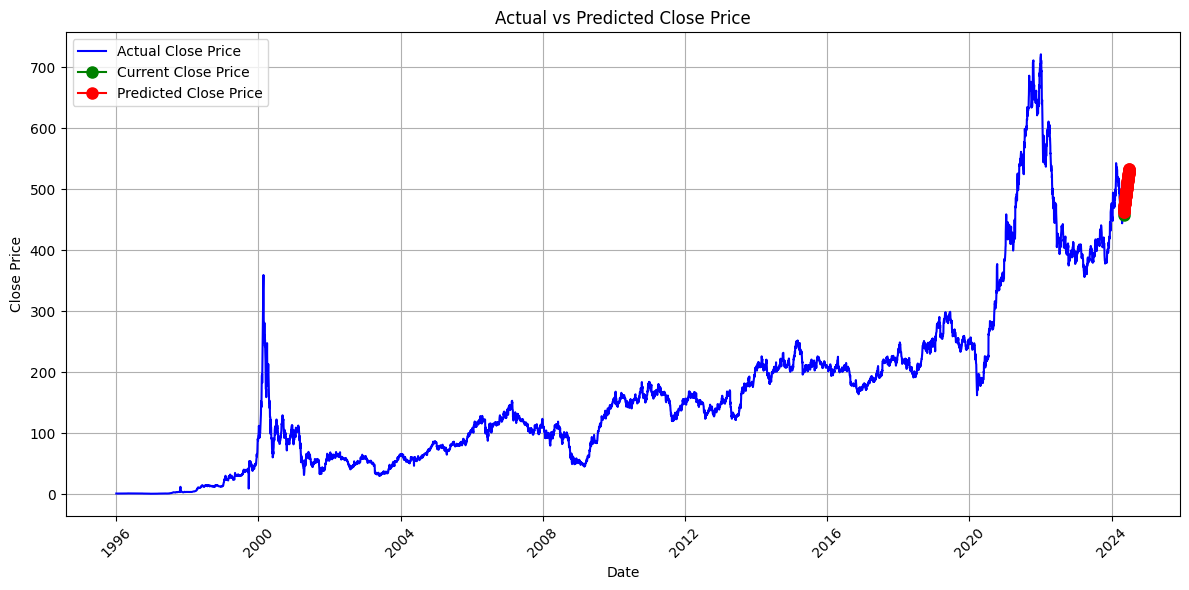

In [106]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
predicted_prices

array([463.05862, 463.27094, 464.57062, 466.20535, 467.80896, 469.27252,
       470.61053, 471.87503, 473.11288, 474.3526 , 475.60553, 476.87244,
       478.14954, 479.43213, 480.71664, 482.00064, 483.28296, 484.56296,
       485.8404 , 487.1151 , 488.38696, 489.65585, 490.92154, 492.1839 ,
       493.44278, 494.69794, 495.94925, 497.19656, 498.43973, 499.67847,
       500.9128 , 502.1425 , 503.3674 , 504.58737, 505.80228, 507.01193,
       508.21625, 509.4151 , 510.60825, 511.79562, 512.9771 , 514.15247,
       515.3217 , 516.4847 , 517.6411 , 518.7911 , 519.93427, 521.0707 ,
       522.2002 , 523.3226 , 524.4379 , 525.5459 , 526.64655, 527.73975,
       528.8253 , 529.90326, 530.97345, 532.0358 , 533.0902 , 534.1365 ],
      dtype=float32)

In [110]:
model.save('WIPRO.h5')

In [111]:
import joblib
joblib.dump(scaler, 'WIPRO_minmax_scaler.pkl')

['WIPRO_minmax_scaler.pkl']